In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

In [2]:
os.chdir("/public/home/CS182/lizj2023-cs182/emo_detect_env/Emotion-detection-Lenvive/src")

print(torch.cuda.is_available() if "cuda" else "cpu")

True


In [3]:
# 设置随机种子保证可重复性
torch.manual_seed(42)
np.random.seed(42)

# 1. 数据加载和预处理
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir, transform=transform)
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


# 定义数据转换
data_transforms = transforms.Compose(
    [
        transforms.Grayscale(),  # 转换为灰度图
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.5], std=[0.5]),  # 标准化
    ]
)

# 加载数据集
train_dataset = EmotionDataset(root_dir="./data/train", transform=data_transforms)
test_dataset = EmotionDataset(root_dir="./data/test", transform=data_transforms)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

In [ ]:

# 2. 搭建CNN神经网络
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 3 * 3)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=3, factor=0.1
)


In [ ]:



# 3. 训练模型
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    train_loss_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item() * inputs.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct / total)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}"
        )

        # 学习率调度
        scheduler.step(epoch_loss)

    return train_loss_history, train_acc_history


# 训练模型
num_epochs = 30
train_loss, train_acc = train_model(
    model, train_loader, criterion, optimizer, num_epochs
)

Test Accuracy: 0.6004

Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.50      0.52       958
   disgusted       0.80      0.42      0.55       111
     fearful       0.41      0.46      0.43      1024
       happy       0.86      0.77      0.81      1774
     neutral       0.49      0.65      0.56      1233
         sad       0.52      0.40      0.45      1247
   surprised       0.72      0.77      0.75       831

    accuracy                           0.60      7178
   macro avg       0.62      0.57      0.58      7178
weighted avg       0.61      0.60      0.60      7178



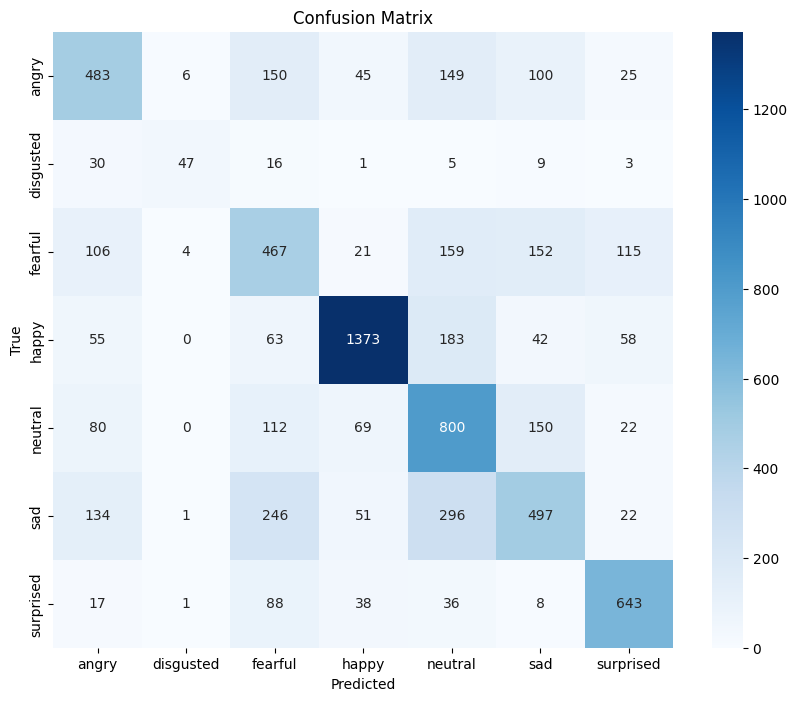

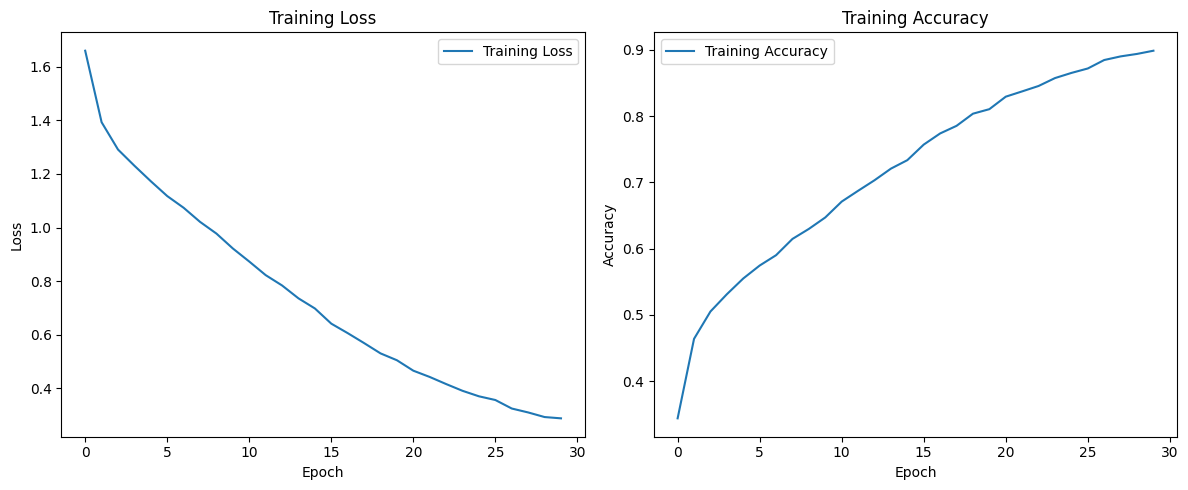

Model saved to emotion_cnn_model.pth


In [6]:
# 4. 评估模型
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    # 生成分类报告和混淆矩阵
    print("\nClassification Report:")
    print(
        classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    )

    # 绘制混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=test_dataset.classes,
        yticklabels=test_dataset.classes,
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return test_acc


# 评估模型
test_accuracy = evaluate_model(model, test_loader)


# 5. 可视化训练过程
def plot_training_history(train_loss, train_acc):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Training Accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# 绘制训练历史
plot_training_history(train_loss, train_acc)

# 保存模型
torch.save(model.state_dict(), "emotion_cnn_model.pth")
print("Model saved to emotion_cnn_model.pth")
